In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pickle
from wordcloud import WordCloud

sns.set()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amlab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amlab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amlab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import re
youtube_df = pd.read_csv('./Data/Youtube_first_trending.csv')

In [3]:
youtube_df.dtypes

Unnamed: 0                 int64
video_id                  object
trending_date             object
title                     object
channel_title             object
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
post_to_trend_days         int64
category_type             object
dtype: object

In [4]:
english = stopwords.words('english')
stopwords_list = []

for words in english:
    stopwords_list.append(words)
        

In [5]:
categories = youtube_df['category_type'].unique()

In [6]:
def extract_tags(category):
    temp = youtube_df[youtube_df['category_type'] == category]
    tags = []
    for t in temp['tags']:
        tags.append(t)
        
    return tags

In [7]:
def clean_tags(tags):
    output = []
    for i in range(len(tags)):
        tags[i] = tags[i].lower()
        tags[i] = re.sub('[^A-Za-z]+', ' ', tags[i]) # to remove punctuation if any 
        tags[i] = tags[i].strip()
        tags[i] = word_tokenize(tags[i]) # it just splits words into individual words
        tags[i] = [w for w in tags[i] if not w in stopwords_list] # removing stopwords
        tags[i] = [word for word in tags[i] if len(word) > 2]  # removing any word whose length is 1 or 2
        tags[i] = [word for word in tags[i] if not word.isdigit()] # removing numerics
        for w in tags[i]:
            output.append(w)
    return output

In [8]:
all = [] # contains final cleaned tags from every individual category
for c in categories:
    tags = extract_tags(c)
    cleaned = clean_tags(tags)
    all.append(cleaned)

In [9]:
def get_polarities(tags):
    max = 2000 # 2000 words to be taken from each category tags
    frequency = nltk.FreqDist(tags) # calculating frequency of each word
    temp = pd.DataFrame(frequency.most_common(max),
                    columns=['Word', 'Frequency'])
    compound = .0 # polarity is initially 0.0
    polarities = []
    for word in temp['Word'].head(max):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    return compound

In [10]:
polarities = [] # list of polarities from tags of individual categories
for a in all:
    polarity = get_polarities(a)
    polarities.append(polarity)

Text(0.5, 1.0, 'Sentiment Analysis')

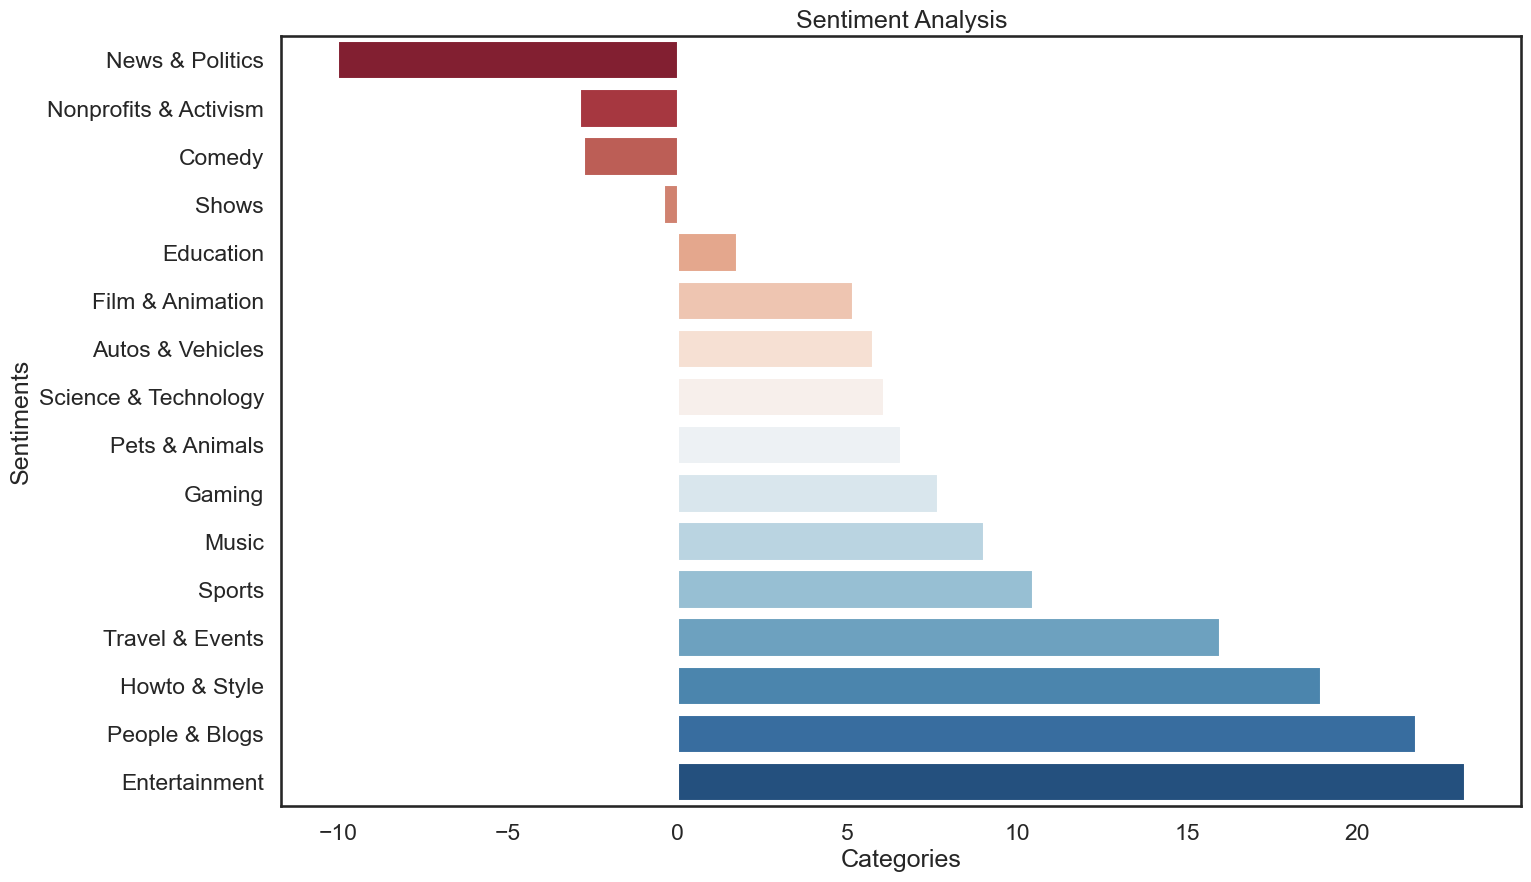

In [11]:
categories = pd.DataFrame(categories)
polarities = pd.DataFrame(polarities)
sentiments = pd.concat([categories, polarities], axis=1)
sentiments.columns = ['category', 'polarity']
sentiments = sentiments.sort_values('polarity').reset_index()
fig = plt.figure(figsize=(16, 10))
sns.set(style="white", context="talk")
ax = sns.barplot(x=sentiments['polarity'], y=sentiments['category'], data=sentiments,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("Sentiments")
plt.title("Sentiment Analysis")

(-0.5, 399.5, 199.5, -0.5)

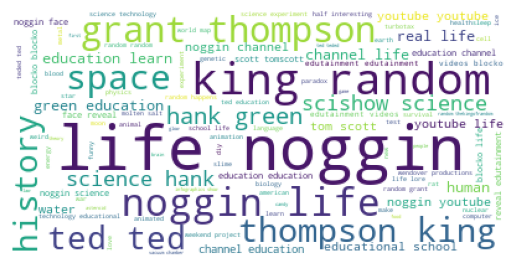

In [12]:
neg = all[9] # 'News and Politics' was at index 9plt.figure(figsize = (20,15))
cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
cloud.generate(' '.join(neg))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

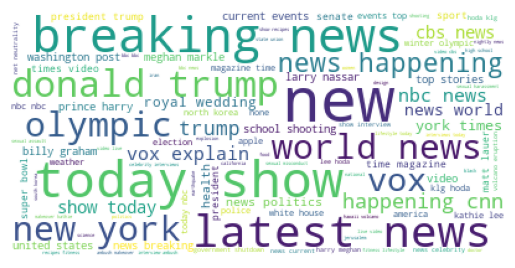

In [13]:
pos = all[5] # 'Howto and Style' was at index 5plt.figure(figsize = (20,15))
cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
cloud.generate(' '.join(pos))
plt.imshow(cloud)
plt.axis('off')

In [14]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [15]:
cwd = os.getcwd()
random.seed( 30 )

df = youtube_df
y = df.views

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [17]:
predictors = ["likes","dislikes"]
x_train = x_train[predictors]
x_test = x_test[predictors]

In [18]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_test)
# To retrieve the intercept
print(lm.intercept_)
# For retrieving the slope
print('regressor coffecient:',lm.coef_)

300660.8578293664
regressor coffecient: [12.42506519 20.53322064]


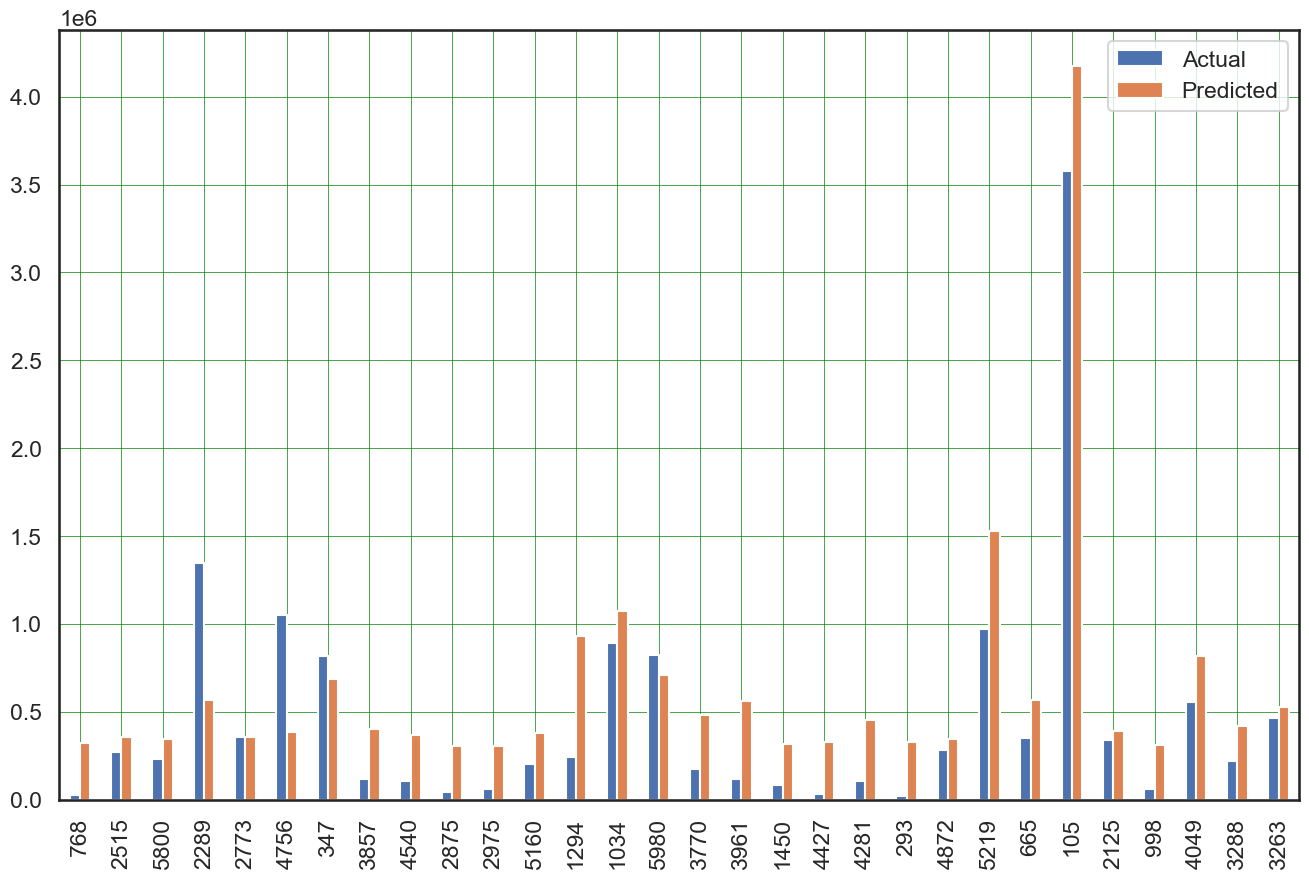

In [19]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()